### 1. Setup and Imports

In [135]:
# Import required libraries
import os
import random
import numpy as np
import tensorflow as tf
import keras
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2

# Print versions and check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2. Set Random Seeds for Reproducibility

In [136]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)
    keras.utils.set_random_seed(seed)

set_seed()

### 3. Data Loading and Preprocessing

In [137]:
def get_data(data_dir, labels, img_size=64, seed=42):
    """
    Load and preprocess image data from directory.
    
    Args:
        data_dir (str): Directory containing image data
        labels (list): List of class labels
        img_size (int): Size to resize images to
        seed (int): Random seed for reproducibility
        
    Returns:
        tuple: Preprocessed features and labels
    """
    np.random.seed(seed)
    random.seed(seed)
    
    x = []
    y = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(f"Processing label: {label}, class_num: {class_num}")
        
        for img in sorted(os.listdir(path)):
            image = Image.open(os.path.join(path, img))
            resized_img = image.resize((img_size, img_size))
            resized_arr = np.array(resized_img)
            x.append(resized_arr)
            y.append(class_num)
            
    return (np.array(x, dtype=int), np.array(y, dtype=int))

# Load data
img_size = 64
labels = ['blue', 'red', 'white', 'fail']

x_test, y_test = get_data("data/test_four_label", labels, img_size)
x_train, y_train = get_data("data/train_four_label", labels, img_size)

Processing label: blue, class_num: 0
Processing label: red, class_num: 1
Processing label: white, class_num: 2
Processing label: fail, class_num: 3
Processing label: blue, class_num: 0
Processing label: red, class_num: 1
Processing label: white, class_num: 2
Processing label: fail, class_num: 3


### 4. Data Analysis and Visualization


Class Distribution:
Test data:
blue: 59
red: 59
white: 57
fail: 179
Total test data: 354

Train data:
blue: 140
red: 140
white: 140
fail: 420
Total train data: 840


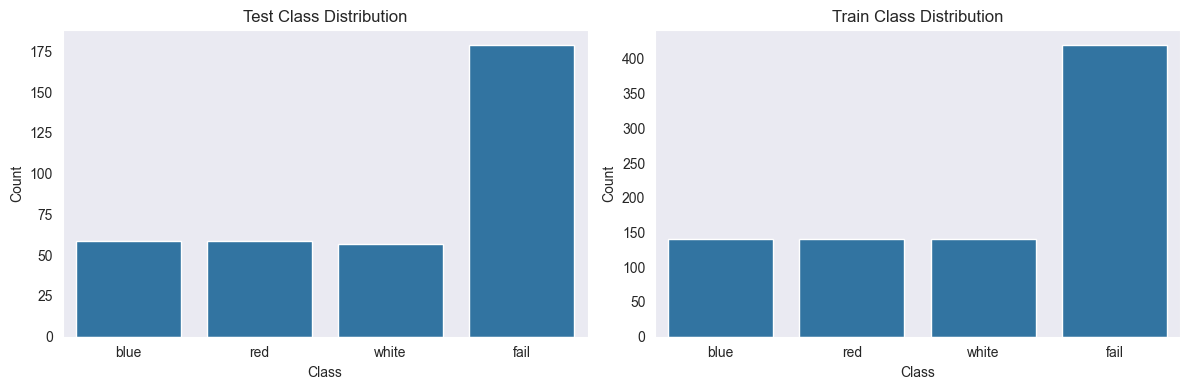

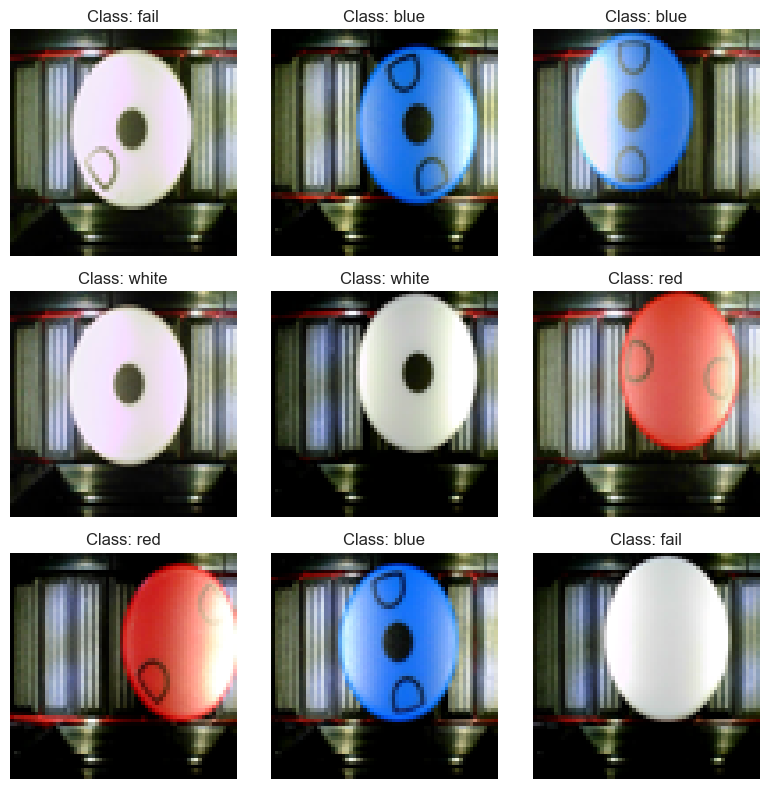

In [138]:
# Count class distribution
test_class_counts = [np.count_nonzero(y_test == i) for i in range(len(labels))]
train_class_counts = [np.count_nonzero(y_train == i) for i in range(len(labels))]

print("\nClass Distribution:")
print("Test data:")
for label, count in zip(labels, test_class_counts):
    print(f"{label}: {count}")
print(f"Total test data: {sum(test_class_counts)}")

print("\nTrain data:")
for label, count in zip(labels, train_class_counts):
    print(f"{label}: {count}")
print(f"Total train data: {sum(train_class_counts)}")

# Visualize class distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=labels, y=test_class_counts)
plt.title("Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.barplot(x=labels, y=train_class_counts)
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Display sample images
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(y_test))
        ax[i,j].imshow(x_test[idx])
        ax[i,j].set_title(f'Class: {labels[y_test[idx]]}')
        ax[i,j].axis('off')
plt.tight_layout()
plt.show()

### 5. Data Preprocessing

In [139]:
def normalize_data(x):
    """Normalize pixel values to [0-1] range"""
    return x.astype('float32') / 255.0

# Normalize data
x_test = normalize_data(x_test)
x_train = normalize_data(x_train)

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = keras.utils.to_categorical(y_test, num_classes=len(labels))

# Print shapes
print("\nData shapes after processing:")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")


Data shapes after processing:
x_train: (840, 64, 64, 3)
y_train: (840, 4)
x_test: (354, 64, 64, 3)
y_test: (354, 4)


In [140]:
# Function for adjusting the learning rate
def scheduler(epoch, lr):
    """
    Learning rate scheduler function.

    Arguments:
    epoch -- the current training epoch number.
    lr -- the current learning rate.

    Returns:
    updated_lr -- the updated learning rate for the next epoch.
    For the first 9 epochs: no changes
    Epoch >= 10: reduce learning rate every epoch by 10%
    """
    try:
        if epoch < 10:
            return float(lr)
        else:
            return float(lr * 0.9)
    except:
        return 0.001 

# Learning rate scheduler callback
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

### 6. Model Definition and Training

In [141]:
def add_layers(model, input_shape, num_classes):
     
    model. add (keras. layers.InputLayer(shape=input_shape))
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=L2(3.5e-06,)))
    model. add (keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model. add (keras.layers.Dropout(0.1))
     
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(8e-06)))
    model. add (keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(4e-05)))
    model. add (keras. layers.MaxPooling2D(pool_size=(2, 2)))
    model. add (keras. layers. Dropout(0.2))
     
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(1.5e-05))) 
    model.add(keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu', kernel_regularizer=L2(2.5e-04)))
    model. add (keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model. add (keras. layers. Dropout (0.3))
     
    model. add (keras. layers.Flatten())
    model. add (keras. layers.Dense(256, activation='elu', kernel_regularizer=L2(7e-05)))
    model. add (keras. layers.BatchNormalization())
    model. add (keras. layers.Dropout(0.4))
    model. add (keras. layers.Dense(512, activation='elu' , kernel_regularizer=L2(3e-06)))
    model. add (keras. layers.BatchNormalization())
    model. add (keras. layers.Dropout(0.4))
    model. add (keras.layers.Dense(num_classes, activation='softmax'))
    

    return model
# Callbacks
callbacks = [
   
   keras.callbacks.ReduceLROnPlateau(
       monitor='val_accuracy',
       factor=0.3,
       patience=5,
       min_lr=0.00001
   )
]




# Create and compile model
keras.backend.clear_session()
set_seed(42)
model = add_layers(keras.Sequential(), x_train.shape[1:], len(labels))
model.compile(
   optimizer=keras.optimizers.RMSprop(learning_rate=0.0004172401899107649),
   loss='categorical_crossentropy',
   metrics=['accuracy'],
    
)

#Training
history = model.fit(
   x_train,
    y_train,
   validation_data=(x_test, y_test),
   epochs=100,
   batch_size=48,
    callbacks=callbacks,
)

Epoch 1/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.3399 - loss: 2.0048 - val_accuracy: 0.5056 - val_loss: 1.2001 - learning_rate: 4.1724e-04
Epoch 2/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4338 - loss: 1.6661 - val_accuracy: 0.5395 - val_loss: 1.1495 - learning_rate: 4.1724e-04
Epoch 3/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4249 - loss: 1.4430 - val_accuracy: 0.5367 - val_loss: 1.1244 - learning_rate: 4.1724e-04
Epoch 4/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4687 - loss: 1.4483 - val_accuracy: 0.5282 - val_loss: 1.1209 - learning_rate: 4.1724e-04
Epoch 5/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5023 - loss: 1.3478 - val_accuracy: 0.5000 - val_loss: 1.0569 - learning_rate: 4.1724e-04
Epoch 6/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5466 - loss: 1.2473 - val_accuracy: 0.5763 - val_loss: 1.0092 - learning_rate: 4.1724e-04
Epoch 7/42
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5664

### 7.Model Evaluation


In [142]:
self_designed_score = model.evaluate(x_test, y_test, verbose=0)


# Print from model history:
print(f"self_designed - Training accuracy: {history.history['accuracy'][-1]:.2f}")
print(f"self_designed - Validation accuracy: {history.history['val_accuracy'][-1]:.2f}\n")

# Print from evaluation step:
print(f"self_designed - Validation loss: {self_designed_score[0]:.2f}")
print(f"self_designed - Validation accuracy: {self_designed_score[1]:.2f}")


self_designed - Training accuracy: 0.94
self_designed - Validation accuracy: 0.93

self_designed - Validation loss: 0.30
self_designed - Validation accuracy: 0.93


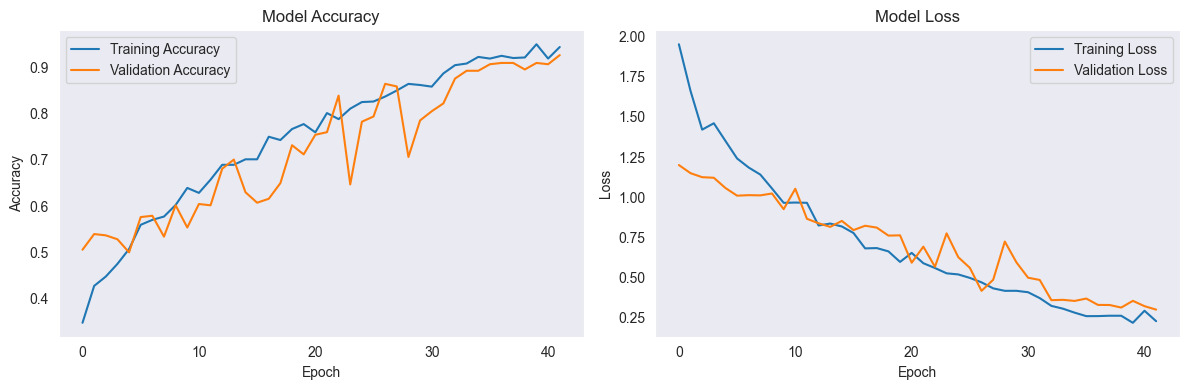

In [143]:
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 8. Detailed Analysis

In [144]:
# Test Function
def test_prediction(image_path):
    """
    Test model prediction on a single image
    """
    # Load and preprocess image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (64, 64))
    input_image = np.array(resized_image, dtype=np.float32)
    input_image = input_image.reshape(1, 64, 64, 3)
    
    # Get prediction
    prediction = model.predict(input_image)
    predicted_label = labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    # Display results
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.3f})")
    plt.axis('off')
    plt.show()
    
    print("\nConfidence scores:")
    for label, conf in zip(labels, prediction[0]):
        print(f"{label}: {conf:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


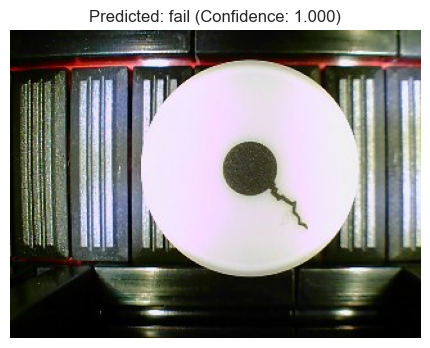


Confidence scores:
blue: 0.000
red: 0.000
white: 0.000
fail: 1.000


In [145]:
test_prediction(f'data/test_four_label/fail/white_fail_157.jpg')

In [146]:
# Evaluate the complete Test-Set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Predictions for all  Test images
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9302 - loss: 0.2804

Test accuracy: 0.9266
Test loss: 0.2989
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


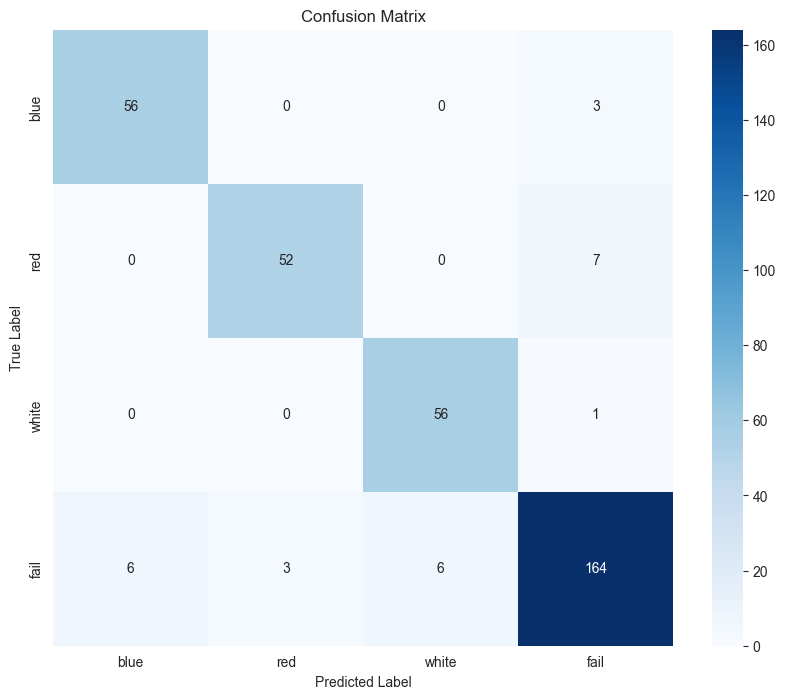


Examples with lowest Confidence:


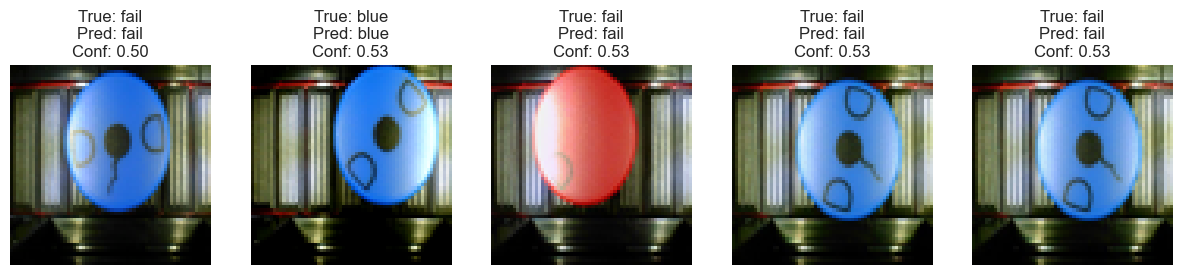


Classification Report:
              precision    recall  f1-score   support

        blue       0.90      0.95      0.93        59
         red       0.95      0.88      0.91        59
       white       0.90      0.98      0.94        57
        fail       0.94      0.92      0.93       179

    accuracy                           0.93       354
   macro avg       0.92      0.93      0.93       354
weighted avg       0.93      0.93      0.93       354



In [147]:
from sklearn.metrics import confusion_matrix, classification_report


def analyze_predictions():
    
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Find misclassified images
    misclassified = np.where(y_pred_classes != y_test_classes)[0]
    
    
    confidences = np.max(y_pred, axis=1)
    least_confident = np.argsort(confidences)[:5]
    
    print("\nExamples with lowest Confidence:")
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(least_confident):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_test[idx])
        true_label = labels[y_test_classes[idx]]
        pred_label = labels[y_pred_classes[idx]]
        conf = confidences[idx]
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
        plt.axis('off')
    plt.show()

    
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=labels))

    return y_pred, y_pred_classes, y_test_classes


y_pred, y_pred_classes, y_test_classes = analyze_predictions()

### 9. Save and Load Model

In [151]:
# save model and its architecture
model.save('models/image_classifier_model.keras')

In [152]:
# Load model
model_loaded = keras.models.load_model('models/image_classifier_model.keras')

# Verify loaded model
test_loss, test_accuracy = model_loaded.evaluate(x_test, y_test, verbose=0)
print(f"\nLoaded Model Performance:")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Loaded Model Performance:
Test accuracy: 0.9266
Test loss: 0.2989


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


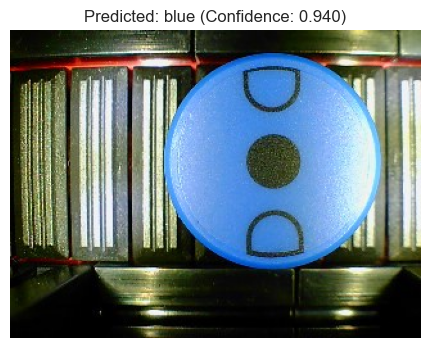


Confidence scores:
blue: 0.940
red: 0.016
white: 0.001
fail: 0.043


In [153]:
def predict_single_image(image_path):
    """
    Make prediction on a single image
    
    Args:
        image_path (str): Path to image file
    """
    # Load and preprocess image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (64, 64))
    input_image = np.array(resized_image, dtype=np.float32)
    input_image = input_image.reshape(1, 64, 64, 3)
    input_image = normalize_data(input_image)
    
    # Get prediction
    prediction = model.predict(input_image)
    predicted_label = labels[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    # Display results
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.3f})")
    plt.axis('off')
    plt.show()
    
    print("\nConfidence scores:")
    for label, conf in zip(labels, prediction[0]):
        print(f"{label}: {conf:.3f}")

predict_single_image('data/test_four_label/blue/blue_002.jpg')